# 9강. 인물사진을 만들어 보자
## 9-2. 셸로우 포커스 만들기 (1) 사진을 준비하자

In [1]:
# 필요한 모듈 import
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

- urllib : 웹에서 데이터 다운로드할 때 사용  
- pixellib : semantic segmentation을 편하게 사용할 수 있는 라이브러리

(240, 320, 3)


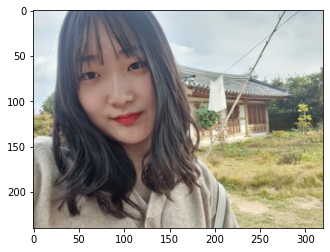

In [2]:
# 이미지 가져오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image_sy.png'
img_orig = cv2.imread(img_path)

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
 # OpenCV는 BGR형식으로 되어있기 때문에 RGB형식으로 변경
plt.show()

## 9-4. 셸로우 포커스 만들기 (3) 시맨틱 세그멘테이션 다뤄보기

In [3]:
# PixelLib에서 제공해 주는 모델 다운로드
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
 # os.path.join(a, b)는 경로를 병합하여 새 경로 생성 model_file 에 "/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5" 저장

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
 # PixelLib가 제공하는 모델의 url

# 다운로드를 시작
urllib.request.urlretrieve(model_url, model_file)
 # request 모듈의 urlretrieve 함수 : model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fbe24491130>)

In [4]:
# 다운로드한 모델을 이용해 PixelLib로 사용할 세그멘테이션 모델을 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)
 # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수

In [5]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)
 # segmentAsPascalvoc()함수 : 입력된 이미지를 분할, 분할 출력의 배열을 가져옴(분할은 pacalvoc 데이터로 학습된 모델을 이용)

In [6]:
# pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

- 라벨은 0부터 시작. tv라벨 = 20(=class_id), person라벨 = 15(=class_id)

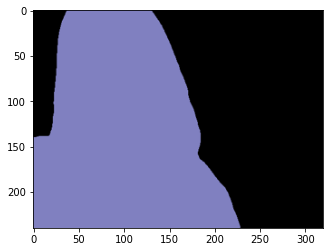

In [7]:
plt.imshow(output)
plt.show()

In [8]:
segvalues 
 # segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력
 # segvalues : class_ids와 masks가 있다.

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]])}

In [9]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [10]:
# 컬러맵 만들기 (output에 어떤 색상으로 나타나 있는지)
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] # 생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
# 사람을 나타내는 15번째 색상
colormap[15]

array([192, 128, 128])

In [12]:
# 색상순서 변경(colormap의 배열은 RGB 순, output의 배열은 BGR 순으로 채널 배치)
seg_color = (128,128,192)

(240, 320)


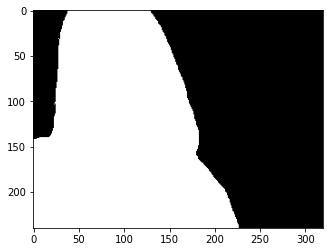

In [13]:
# seg_color로만 이루어진 마스크 만들기
seg_map = np.all(output==seg_color, axis=-1)
 # output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
 # 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
 # seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
 # cmap 값을 변경하면 다른 색상으로 확인이 가능
plt.show()

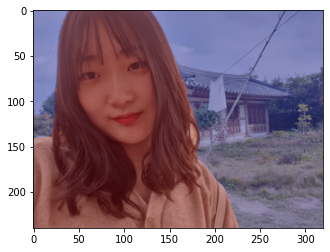

In [14]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔주기
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔보기
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐보기
# 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 9-5. 셸로우 포커스 만들기 (4) 배경 흐리게 하기

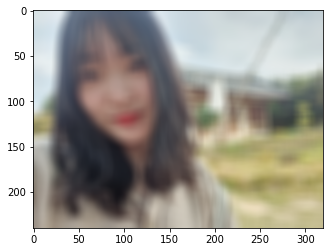

In [15]:
img_orig_blur = cv2.blur(img_orig, (13,13))
 # (13,13)은 blurring kernel size로 변경 가능
    
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

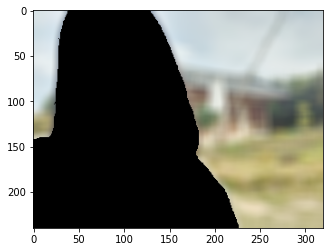

In [17]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출하기
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

- cv2.bitwise_not(): 이미지가 반전(마스크에서 배경이 0, 사람이 255 -> 배경이 255, 사람이 0)  
- cv2.bitwise_and(): 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 된다. (0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문) -> 사람은 사라지고 배경만 남는다.

## 9-6. 셸로우 포커스 만들기 (5) 흐린 배경과 원본 영상 합성

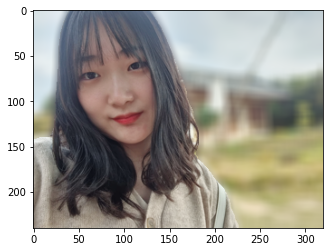

In [18]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

- np.where : (조건, 참일때, 거짓일때)